In [104]:
import numpy as np
import os, sys, glob, abc
%matplotlib inline
from matplotlib import pyplot as plt, colors
def read(filelist):
    data = []
    for f in sorted(filelist):
        x = np.load(f)
        if len(data) == 0: data = x.copy()
        else: data = np.concatenate([data, x])
    return data

# Where is the dataset stored?
dataset = "/data/i3store/users/mjlarson/student_data"

# Read in all of the data files
data_files = dataset + "/IC86_*exp.npy"
data = read(glob.glob(data_files))

# Read in all of the MC files 
sim_files = dataset + "/IC86*MC*npy"
sim = read(glob.glob(sim_files))

# Set the angular error floor to 0.2 degrees
data['angErr'][data['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
sim['angErr'][sim['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)

data['ra']=np.random.uniform(0,2*np.pi,size=len(data))

In [105]:
import mla.core
from mla.spectral import *
import threeML
#sp= PowerLaw(1,1e-15,2)
sp=threeML.Powerlaw()


In [106]:
from mla.spectral import *
from mla import injection
sp= PowerLaw(1,1e-15,2)
dec = 22.0145*np.pi/180
ra = 83.63*np.pi/180
inj = injection.PSinjector(sp,sim)
inj.set_source_location(ra,dec)
sample=inj.sample_nevents(15)
background = np.random.choice(data, 30).copy()


In [107]:
import numpy.lib.recfunctions as rf
sample = rf.drop_fields(sample, [n for n in sample.dtype.names \
             if not n in background.dtype.names])
injected = np.concatenate([background,sample])
np.save("testdata.npy",injected)

In [108]:
from imp import reload
import scipy.optimize
reload(mla.core)
#sp.K=1e-8
#sp.index=-2
sp= PowerLaw(1,1e-15,2)
testdata=np.load("testdata.npy")

test=mla.core.LLH_point_source(np.radians(83.63) ,np.radians(22.0145) , data , sim , 300 , sp)
test.update_data(testdata,1000/3600/24)
#test.add_injection(sample)
import warnings
warnings.filterwarnings("ignore")

In [109]:
def fit(ns):
    return -test.eval_llh_ns(ns)[1]
result=scipy.optimize.minimize(fit,5,bounds=[(0,test.N)])

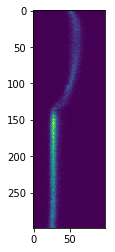

In [119]:
plt.imshow(test.bg_h)

In [112]:
x=np.linspace(0,test.N,100)
temp=[]
ns_true = (testdata['run']>200000).sum()
for i in x:
    temp.append(fit(i))

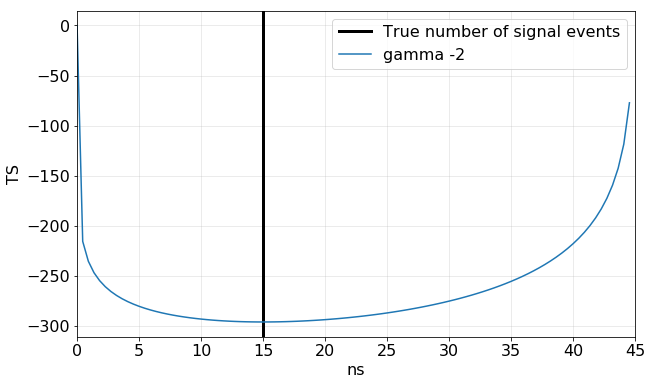

In [113]:
fig, ax = plt.subplots(figsize=(10,6))
ax.axvline(ns_true,
            color='k',
           linewidth=3,
            label = 'True number of signal events')
ax.plot(x,temp,label = 'gamma '+str(-2))
ax.grid(alpha=0.3)
ax.set_xlim(0, len(testdata))
ax.legend(fontsize=16,)
ax.set_xlabel("ns", fontsize=16)
ax.set_ylabel("TS", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [30]:
test.N

6